In [13]:
import os 
import json
import numpy as np
import pandas as pd

import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

from sklearn.preprocessing import StandardScaler

from config import OUTLIER_THRESHOLD_NUM_STD

In [14]:
def detect_outliers_z_score(data, threshold=OUTLIER_THRESHOLD_NUM_STD):
    outliers = []
    mean = np.mean(data)
    std_dev = np.std(data)
    
    for i in data:
        z_score = (i - mean) / std_dev 
        if np.abs(z_score) > threshold:
            outliers.append(i)
    return outliers

In [15]:
DATA_FOLDER = os.path.join("..","data")
OUTPUT_FOLDER = os.path.join("..", "data_binary_scaled")

DATASETS = ['gaussian_df.csv', "rectangle_df.csv", "uniform_df.csv", "wine.csv",
            "breast-cancer-wisconsin.csv"]

In [46]:
for path in DATASETS:
    print(path)
    df = pd.read_csv(os.path.join(DATA_FOLDER, path))
    
    last_column = df.columns[-1]   
    assert last_column == "labels", "Last column is not labels"
     # last column is the label
    df_not_label = df.iloc[:, :-1]
    data_labels = df[last_column]
    
    assert data_labels.nunique() == 2, "Data is not binary"
    
    kmeans = KMeans(n_clusters=2, random_state=42, n_init="auto")

    # perform standard scaling
    st_scaler = StandardScaler().fit(df_not_label)
    print(df_not_label.columns) 
    # break
    df_scale = st_scaler.scale_
    df_mean = st_scaler.mean_
    df_var = st_scaler.var_ 
    
    df_not_label = st_scaler.transform(df_not_label)
    
    kmeans_labels = kmeans.fit_predict(df_not_label)
    
    silhouette = silhouette_score(df_not_label, kmeans_labels)
    calinski_harabasz = calinski_harabasz_score(df_not_label, kmeans_labels)
    inertia = kmeans.inertia_
    print(f"Silhouette score for {path} is {silhouette}")
    print(f"Calinski Harabasz score for {path} is {calinski_harabasz}")
    print(f"Inertia for {path} is {inertia}")
    print()
    df.iloc[:, :-1] = df_not_label
    
    df["labels_kmeans"] = kmeans_labels
    
    # if df.shape[1] == 3:
    #     print(path)
    #     fig = px.scatter(df, x=df.columns[0], y=df.columns[1], color="labels_kmeans")
    #     fig.show()
    #     fig = px.scatter(df, x=df.columns[0], y=df.columns[1], color="labels")
    #     fig.show()
    
    # calculate each points distance to the centroids
    df["distance_to_centroid"] = np.min(
        np.linalg.norm(df_not_label[:, np.newaxis] - kmeans.cluster_centers_, axis=2), axis=1)

    # detect outliers
    outliers = detect_outliers_z_score(df["distance_to_centroid"])

    df["outlier"] = df["distance_to_centroid"].apply(lambda x: x in outliers)

    df_okay = df[~df["outlier"]]

    # normalize distance to centroid for each cluster
    df["distance_to_centroid_norm"] = df_okay.groupby("labels_kmeans")["distance_to_centroid"].transform(
        lambda x: (x - x.min()) / (x.max() - x.min()))
    
    # make "labels_kmeans" be the last column
    cols_to_drop = ["distance_to_centroid", "outlier"]
    
    df = df[[col for col in df.columns if col not in ["labels_kmeans"] + cols_to_drop] + ["labels_kmeans"]]
    
    
    res = {"scale": list(df_scale), "mean": list(df_mean), "var": list(df_var), "silhouette": silhouette, 
           "inertia": inertia, "calinski_harabasz": calinski_harabasz}
    print(res)
    
    PATH = os.path.join(OUTPUT_FOLDER, "results")
    with open(os.path.join(PATH, f"kmeans_{path.split('.')[0]}.json"), "w") as f:
        json.dump(res, f, indent=4)
    
    df.to_csv(os.path.join(OUTPUT_FOLDER, f"kmeans_{path}"), index=False)
    


gaussian_df.csv
Index(['x', 'y'], dtype='object')
Silhouette score for gaussian_df.csv is 0.6314108025017449
Calinski Harabasz score for gaussian_df.csv is 1429.3779750632616
Inertia for gaussian_df.csv is 258.38211624456005

{'scale': [0.5652842657018544, 0.4387547517707988], 'mean': [0.6853238581396945, 0.5424825002224375], 'var': [0.3195463010500848, 0.19250573220145528], 'silhouette': 0.6314108025017449, 'inertia': 258.38211624456005, 'calinski_harabasz': 1429.3779750632616}
rectangle_df.csv
Index(['x', 'y'], dtype='object')
Silhouette score for rectangle_df.csv is 0.36572869957661264
Calinski Harabasz score for rectangle_df.csv is 793.9603091328796
Inertia for rectangle_df.csv is 1550.0659628406986

{'scale': [0.5808503703050264, 0.6307002214321649], 'mean': [-0.020608868443798903, -0.015883336495619016], 'var': [0.3373871526834863, 0.39778276931458184], 'silhouette': 0.36572869957661264, 'inertia': 1550.0659628406986, 'calinski_harabasz': 793.9603091328796}
uniform_df.csv
Index([

C:\Users\hayk_\AppData\Local\Temp\ipykernel_12684\2624508132.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.93722961 -0.93722961 -0.93722961 ...  0.20799905  1.35322771
  0.20799905]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:, :-1] = df_not_label
C:\Users\hayk_\AppData\Local\Temp\ipykernel_12684\2624508132.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.49460693 -0.49460693 -0.49460693 ... -0.49460693  2.0218075
 -0.49460693]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:, :-1] = df_not_label
C:\Users\hayk_\AppData\Local\Temp\ipykernel_12684\2624508132.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.19790469  0.19790469 -0.51164337  0.552

{'scale': [2.81869558343092, 3.0629001503544044, 2.986392183232257, 2.862464378235597, 2.221457418540208, 3.6411886451877287, 2.447902579908637, 3.0504308399902413, 1.7314052526140433], 'mean': [4.44216691068814, 3.150805270863836, 3.2152269399707176, 2.830161054172767, 3.234260614934114, 3.5446559297218156, 3.445095168374817, 2.869692532942899, 1.603221083455344], 'var': [7.945044792052974, 9.381357331041032, 8.918538272070725, 8.193702316667704, 4.934873062387323, 13.258254749844047, 5.992227040723361, 9.30512830956357, 2.9977641487794995], 'silhouette': 0.5734443556359308, 'inertia': 2728.435818684855, 'calinski_harabasz': 853.2515925545065}


C:\Users\hayk_\AppData\Local\Temp\ipykernel_12684\2624508132.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.5556085   1.69516613 -0.5556085  -0.10545357 -0.5556085   1.69516613
 -0.5556085  -0.5556085  -0.5556085  -0.5556085  -1.00576342 -0.5556085
 -0.5556085  -0.5556085   1.69516613  1.24501121 -0.5556085  -0.5556085
  0.34470136 -0.5556085   0.79485628  1.24501121 -0.5556085  -0.5556085
 -0.5556085  -1.00576342 -0.5556085  -0.5556085  -0.5556085  -1.00576342
 -0.5556085   2.14532106 -0.5556085  -0.5556085  -0.5556085   1.24501121
 -1.00576342 -0.5556085   1.24501121 -0.10545357  2.14532106  3.04563091
  2.14532106 -0.5556085   0.34470136 -0.5556085  -0.5556085   0.34470136
 -0.5556085  -0.5556085  -0.10545357  3.04563091  2.14532106  0.34470136
 -0.10545357  0.79485628  1.24501121 -0.5556085  -0.10545357 -0.5556085
  3.04563091  0.79485628 -0.5556085  -0.10545357 -0.5556085   2.14532106
  0.34470136 -0

## DBSCAN

Found the desired number of clusters: 2 at eps=0.22000000000000008


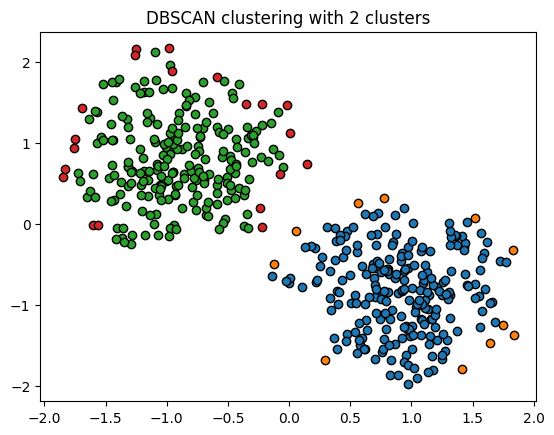

In [56]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler

# Generating sample data
# X, _ = make_moons(n_samples=300, noise=0.1, random_state=42)

path = os.path.join(OUTPUT_FOLDER, "kmeans_gaussian_df.csv")	
df = pd.read_csv(path)

X = df[[df.columns[0], df.columns[1]]].values
X_scaled = StandardScaler().fit_transform(X)  # Scaling is important for DBSCAN

# Initialization
eps = 0.1  # Initial epsilon value
step = 0.01  # Step size for epsilon increment
max_eps = 2  # Maximum epsilon boundary
min_samples = 5  # You can adjust this based on data density
target_clusters = 2  # Desired number of clusters excluding noise
current_clusters = 0  # To store the number of clusters found

# Iterate to find the suitable 'eps' value
while current_clusters != target_clusters and eps <= max_eps:
    # DBSCAN with current eps and min_samples
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(X_scaled)
    labels = db.labels_
    
    # Exclude noise labels and count unique clusters
    unique_labels = set(labels)
    if -1 in unique_labels:
        unique_labels.remove(-1)
    current_clusters = len(unique_labels)
    
    # Check if we have the desired number of clusters
    if current_clusters == target_clusters:
        print(f"Found the desired number of clusters: {current_clusters} at eps={eps}")
        break
    else:
        eps += step

# If the loop completes without breaking
if current_clusters != target_clusters:
    print("Could not find the exact number of desired clusters with the given parameters.")
else:
    # Further analysis or visualization can go here
    import matplotlib.pyplot as plt
    
    # Plotting results
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    for k in unique_labels:
        class_member_mask = (labels == k)
        
        xy = X_scaled[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markeredgecolor='k')
        
        xy = X_scaled[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markeredgecolor='k')
    
    plt.title('DBSCAN clustering with 2 clusters')
    plt.show()

    # save the results
    df["labels_dbscan"] = db.labels_

c:\Users\hayk_\.conda\envs\thesis\lib\site-packages\matplotlib\transforms.py:2038: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self._mtx[0, 2] += tx
c:\Users\hayk_\.conda\envs\thesis\lib\site-packages\matplotlib\transforms.py:2039: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self._mtx[1, 2] += ty


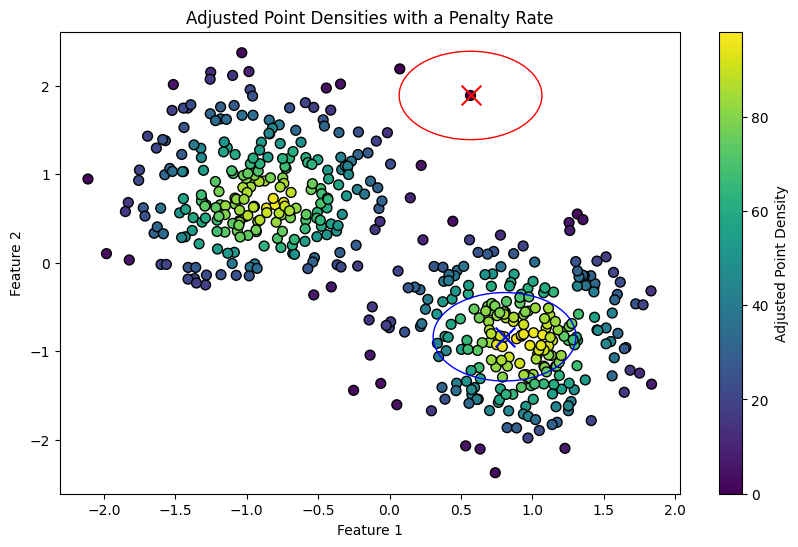

In [75]:
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

def calculate_adjusted_density(data, labels, radius, penalty_rate=0.5):
    """
    Calculate the adjusted density of each point in the dataset based on the number of points within a specified radius.
    The density score is penalized if neighboring points belong to a different class.

    Args:
    - data (numpy array): The dataset where each row is a point in space.
    - labels (numpy array): Class labels corresponding to each data point.
    - radius (float): The radius of the ball within which to count neighboring points.
    - penalty_rate (float): Penalty multiplier for points from different classes within the radius.
    
    Returns:
    - densities (numpy array): An array where each element is the adjusted density of the corresponding point in 'data'.
    """
    tree = cKDTree(data)
    densities = np.zeros(data.shape[0])
    
    for i, point in enumerate(data):
        indices = tree.query_ball_point(point, r=radius)
        class_counts = np.sum(labels[indices] != labels[i])
        # Calculate density with penalty for different class points
        densities[i] = len(indices) - 1 - (class_counts * penalty_rate)

    return densities

# Example data generation
# X, y = make_blobs(n_samples=200, centers=3, random_state=42, cluster_std=5)

X = df[[df.columns[0], df.columns[1]]].values
y = df["labels_dbscan"].values

# Radius within which to count neighbors
radius = 0.5

# Calculate adjusted densities
adjusted_densities = calculate_adjusted_density(X, y, radius, penalty_rate=0.5)

df["distance"] = adjusted_densities


point_min = df[df["distance"] == df["distance"].min()]
point_max = df[df["distance"] == df["distance"].max()]

# Plotting
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=adjusted_densities, cmap='viridis', edgecolor='k', s=50)
plt.colorbar(scatter, label='Adjusted Point Density')
plt.title('Adjusted Point Densities with a Penalty Rate')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.scatter(point_min[point_min.columns[0]], point_min[point_min.columns[1]], c='red', s=200, marker='x', label='Min')
plt.scatter(point_max[point_max.columns[0]], point_max[point_max.columns[1]], c='blue', s=200, marker='x', label='Max')

# plot circle if radius 2 around the point
circle_min = plt.Circle((point_min[point_min.columns[0]], point_min[point_min.columns[1]]), radius, color='red', fill=False)
circle_max = plt.Circle((point_max[point_max.columns[0]], point_max[point_max.columns[1]]), radius, color='blue', fill=False)

plt.gca().add_artist(circle_min)
plt.gca().add_artist(circle_max)
plt.show()